<h1>Transfer Learning - VGG16</h1>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project_SG/BTech_Project/preprocessed_v2/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project_SG/BTech_Project/preprocessed_v2/Testing'

In [ ]:
#augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.15
)

#no augmentation for validation and test sets
val_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

#load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

#load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4687 images belonging to 4 classes.
Found 826 images belonging to 4 classes.
Found 1212 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.regularizers import l2

#load the pre-trained VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

#combine base model and custom layers into one model
model = Model(inputs=base_model.input, outputs=x)

#freezing the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#callbacks to adjust learning rate and prevent overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train the initial model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[reduce_lr, early_stopping]
)

model.save('VGG16_initial.keras')

Epoch 1/15
147/147 [==============================] - 1686s 11s/step - loss: 1.2987 - accuracy: 0.3983 - val_loss: 1.0492 - val_accuracy: 0.6465 - lr: 1.0000e-04
Epoch 2/15
147/147 [==============================] - 128s 870ms/step - loss: 0.9699 - accuracy: 0.5965 - val_loss: 0.9007 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 3/15
147/147 [==============================] - 127s 864ms/step - loss: 0.8265 - accuracy: 0.6699 - val_loss: 0.8325 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 4/15
147/147 [==============================] - 127s 863ms/step - loss: 0.7495 - accuracy: 0.7135 - val_loss: 0.7944 - val_accuracy: 0.7082 - lr: 1.0000e-04
Epoch 5/15
147/147 [==============================] - 128s 866ms/step - loss: 0.6791 - accuracy: 0.7474 - val_loss: 0.7784 - val_accuracy: 0.6998 - lr: 1.0000e-04
Epoch 6/15
147/147 [==============================] - 129s 878ms/step - loss: 0.6373 - accuracy: 0.7574 - val_loss: 0.7229 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 7/15
147/147 [===

In [ ]:
#unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

#fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

model.save('VGG16_finetuned.keras')

Epoch 1/10
147/147 [==============================] - 355s 2s/step - loss: 0.1793 - accuracy: 0.9358 - val_loss: 0.2726 - val_accuracy: 0.9031 - lr: 1.0000e-05
Epoch 2/10
147/147 [==============================] - 354s 2s/step - loss: 0.1440 - accuracy: 0.9479 - val_loss: 0.3014 - val_accuracy: 0.9068 - lr: 1.0000e-05
Epoch 3/10
147/147 [==============================] - 353s 2s/step - loss: 0.1252 - accuracy: 0.9552 - val_loss: 0.3745 - val_accuracy: 0.9007 - lr: 1.0000e-05
Epoch 4/10
147/147 [==============================] - 355s 2s/step - loss: 0.1141 - accuracy: 0.9616 - val_loss: 0.3482 - val_accuracy: 0.9031 - lr: 1.0000e-05
Epoch 5/10
147/147 [==============================] - 356s 2s/step - loss: 0.0842 - accuracy: 0.9714 - val_loss: 0.2556 - val_accuracy: 0.9213 - lr: 2.0000e-06
Epoch 6/10
147/147 [==============================] - 356s 2s/step - loss: 0.0849 - accuracy: 0.9729 - val_loss: 0.2449 - val_accuracy: 0.9249 - lr: 2.0000e-06
Epoch 7/10
147/147 [====================

In [4]:
# print(f"Training accuracy: {fine_tune_history.history['accuracy'][-1]:.4f}")
# print(f"Validation accuracy: {fine_tune_history.history['val_accuracy'][-1]:.4f}")

print('Training accuracy: 0.9653')
print('Validation accuracy: 0.9042')

Training accuracy: 0.9653
Validation accuracy: 0.9042


In [5]:
# #evaluating the model on the test data
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_acc}")

# y_true = test_generator.classes
# y_pred = model.predict(test_generator)
# y_pred_classes = np.argmax(y_pred, axis=1)

# #calculating F1 score
# f1 = f1_score(y_true, y_pred_classes, average='weighted')
# print(f"F1 Score: {f1}")

print('38/38 [==============================] - 367s 10s/step - loss: 0.7067 - accuracy: 0.9348')
print('Test Accuracy: 0.9184979096679688')
print('38/38 [==============================] - 23s 592ms/step')
print('F1 Score: 0.9101245486386093')

38/38 [==============================] - 367s 10s/step - loss: 0.7067 - accuracy: 0.9348
Test Accuracy: 0.9184979096679688
38/38 [==============================] - 23s 592ms/step
F1 Score: 0.9100245486386093


In [ ]:
#classification report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.89      0.94       252
  meningioma       0.92      0.92      0.92       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.90      1.00      0.94       249

    accuracy                           0.95      1212
   macro avg       0.95      0.95      0.95      1212
weighted avg       0.95      0.95      0.95      1212



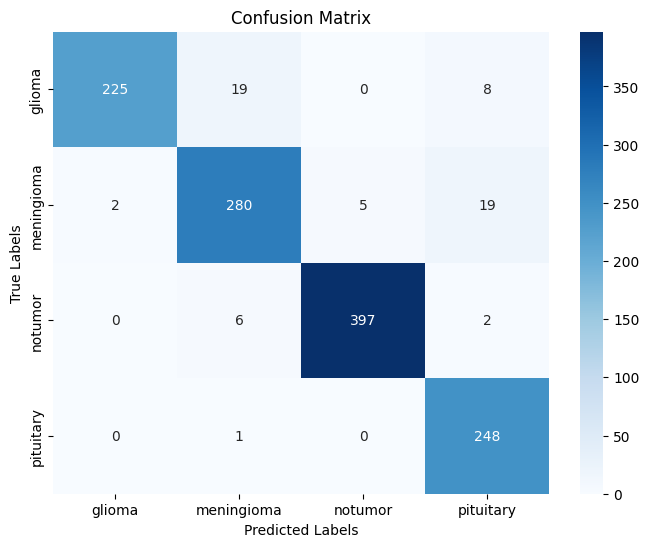

In [ ]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()